# Facebook

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [5]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-56287a27-f91b-91f7-6655-26ce55f92833)


# Explore Data and Preprocessing

In [6]:
# Load dataset
df = pd.read_csv('FB.csv', parse_dates=['Date'],index_col=['Date'])
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200
...,...,...,...,...,...,...
2020-03-26,158.250000,164.000000,157.020004,163.339996,163.339996,26556800
2020-03-27,158.199997,160.089996,154.750000,156.789993,156.789993,24879900
2020-03-30,159.179993,166.750000,158.059998,165.949997,165.949997,22515200


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1980 entries, 2012-05-18 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1980 non-null   float64
 1   High       1980 non-null   float64
 2   Low        1980 non-null   float64
 3   Close      1980 non-null   float64
 4   Adj Close  1980 non-null   float64
 5   Volume     1980 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 108.3 KB


In [8]:
# Take only column 'Close'
FB_stock = pd.DataFrame(df["Close"])
FB_stock.head(20)

,Close
Date,
2012-05-18,38.230000
2012-05-21,34.029999
2012-05-22,31.000000
2012-05-23,32.000000
2012-05-24,33.029999
2012-05-25,31.910000
2012-05-29,28.840000
2012-05-30,28.190001
2012-05-31,29.600000


In [9]:
FB_stock.describe()

,Close
count,1980.000000
mean,112.312207
std,58.133793
min,17.730000
25%,64.762499
50%,113.810001
75%,168.085003
max,223.229996


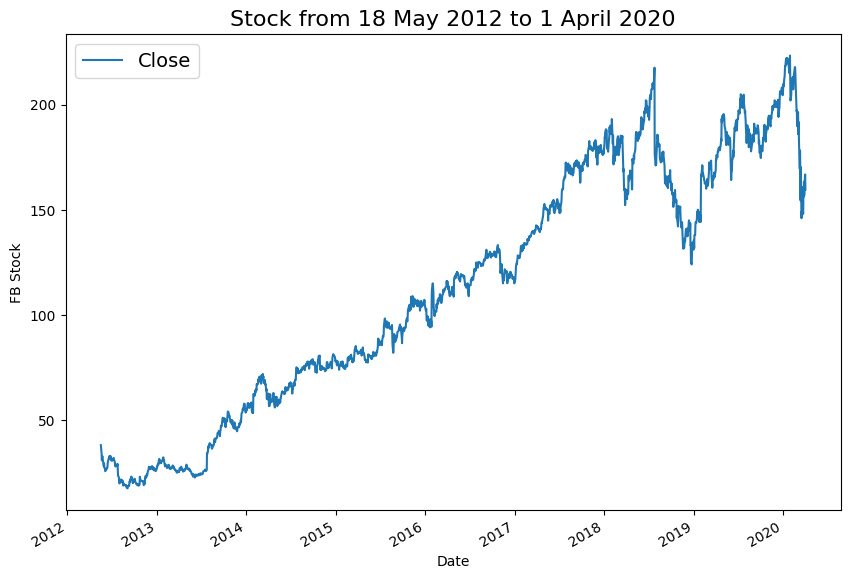

In [77]:
# Plot the time series
FB_stock.plot(figsize=(10, 7))
plt.ylabel("FB Stock") # Label for y-axis
plt.title("Stock from 18 May 2012 to 1 April 2020", fontsize=16) # Title for plot
plt.legend(fontsize=14); #Legend for the plot

The stock price shows a clear upward trend from 2012 to early 2020, indicating overall growth during this period.

In [11]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [12]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=5):
  # Convert date strings from input to datetime objects
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date # Start with the first_date

  dates = [] # List to store target dates
  X, Y = [], []  # Lists to store sequences (X) and targets (Y)

  last_time = False # Flag to terminate loop when last_date is reached
  while True:
    # Extract a subset of the dataframe up to target_date and take the last (n+1) rows
    df_subset = dataframe.loc[:target_date].tail(n+1)

    # Check if the window size is too large for the current target_date
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date) # Append target_date to dates list
    X.append(x) # Append x (input sequence) to X list
    Y.append(y) # Append y (target value) to Y list

    # Find the next week's data based on the current target_date
    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    # Exit loop if it's the last iteration
    if last_time:
      break

    # Update target_date to the next_date for the next iteration
    target_date = next_date

    if target_date == last_date:
      last_time = True

  # Create a new DataFrame to return the results
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  # Add columns for each element in the input sequence (X)
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y # Add 'Target' column with Y list (targets)

  return ret_df

# Start day second time around: '2012-05-29'
windowed_df = df_to_windowed_df(FB_stock,
                                '2012-05-25',
                                '2020-04-01',
                                n=5)
windowed_df

,Target Date,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2012-05-25,38.230000,34.029999,31.000000,32.000000,33.029999,31.910000
1,2012-05-29,34.029999,31.000000,32.000000,33.029999,31.910000,28.840000
2,2012-05-30,31.000000,32.000000,33.029999,31.910000,28.840000,28.190001
3,2012-05-31,32.000000,33.029999,31.910000,28.840000,28.190001,29.600000
4,2012-06-01,33.029999,31.910000,28.840000,28.190001,29.600000,27.719999
...,...,...,...,...,...,...,...
1970,2020-03-26,153.130005,149.729996,148.100006,160.979996,156.210007,163.339996
1971,2020-03-27,149.729996,148.100006,160.979996,156.210007,163.339996,156.789993
1972,2020-03-30,148.100006,160.979996,156.210007,163.339996,156.789993,165.949997
1973,2020-03-31,160.979996,156.210007,163.339996,156.789993,165.949997,166.800003


In [13]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1975,), (1975, 5, 1), (1975,))

# Split Data

In [14]:
# Calculate the split index for 80% training data
split_size80 = int(0.8 * len(dates)) # 80% train, 20% test

# Calculate the split index for 90% training and validation data
split_size90 = int(0.9 * len(dates)) # 90% train, 10% test

# Create train data splits (first 80% of the data)
dates_train, X_train, y_train = dates[:split_size80], X[:split_size80], y[:split_size80]
# Create validation data splits (next 10% of the data)
dates_val, X_val, y_val = dates[split_size80:split_size90], X[split_size80:split_size90], y[split_size80:split_size90]
# Create test data splits (last 10% of the data)
dates_test, X_test, y_test = dates[split_size90:], X[split_size90:], y[split_size90:]

# Print the lengths of the training, validation, and test datasets
print('Lenght of of X_train, y_train :', len(X_train), len(y_train))
print('Lenght of of X_val, y_val :', len(X_val), len(y_val))
print('Lenght of of X_test, y_test :', len(X_test), len(y_test))

Lenght of of X_train, y_train : 1580 1580
Lenght of of X_val, y_val : 197 197
Lenght of of X_test, y_test : 198 198


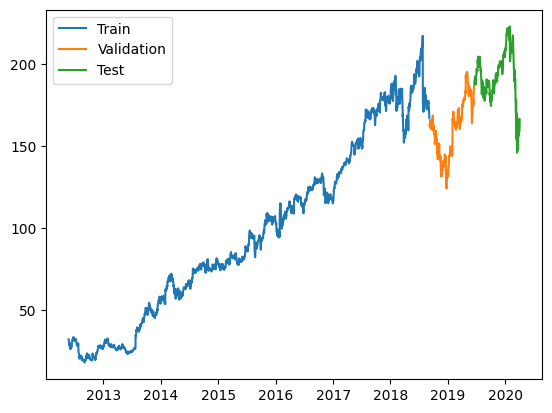

In [15]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

# Arsitektur Baseline

In [16]:
# Create a Sequential model
model = Sequential([
    layers.LSTM(50, activation='relu', input_shape=(5, 1)),  # LSTM layer with 50 units and ReLU activation
    layers.Dense(1)  # Dense layer with 1 node as the output
])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
50/50 [==============================] - 5s 15ms/step - loss: 6368.5029 - mean_absolute_error: 62.7497 - val_loss: 492.9354 - val_mean_absolute_error: 20.8787
Epoch 2/100
50/50 [==============================] - 0s 9ms/step - loss: 43.3959 - mean_absolute_error: 4.2844 - val_loss: 37.0292 - val_mean_absolute_error: 4.5414
Epoch 3/100
50/50 [==============================] - 0s 8ms/step - loss: 12.6848 - mean_absolute_error: 2.3662 - val_loss: 32.2673 - val_mean_absolute_error: 4.2951
Epoch 4/100
50/50 [==============================] - 0s 9ms/step - loss: 11.5741 - mean_absolute_error: 2.2097 - val_loss: 29.8537 - val_mean_absolute_error: 4.1025
Epoch 5/100
50/50 [==============================] - 0s 9ms/step - loss: 10.3156 - mean_absolute_error: 2.0384 - val_loss: 25.5031 - val_mean_absolute_error: 3.7740
Epoch 6/100
50/50 [==============================] - 0s 9ms/step - loss: 9.8397 - mean_absolute_error: 2.0138 - val_loss: 23.5979 - val_mean_absolute_error: 3.6223
Epoch

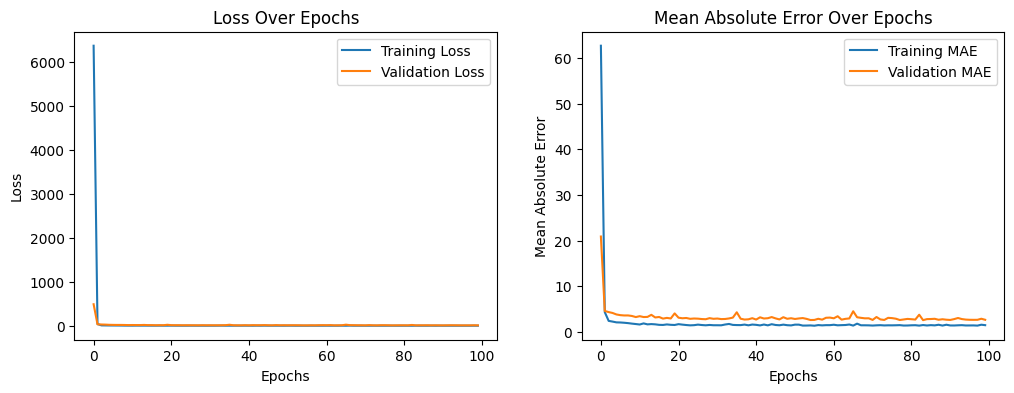

In [17]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

Pada epoch pertama, model menunjukkan nilai loss dan mean_absolute_error (MAE) yang sangat tinggi baik pada data pelatihan maupun validasi. Namun, pada epoch kedua dan seterusnya, terdapat perbaikan yang signifikan dalam nilai-nilai ini.

Setelah epoch ke-50, nilai loss dan MAE pada data validasi menunjukkan fluktuasi yang lebih besar dan tidak menunjukkan penurunan yang signifikan. Ini bisa menjadi indikasi bahwa model mulai mengalami overfitting, di mana performa pada data pelatihan terus membaik namun performa pada data validasi tidak menunjukkan peningkatan yang sama.

50/50 [==============================] - 0s 4ms/step


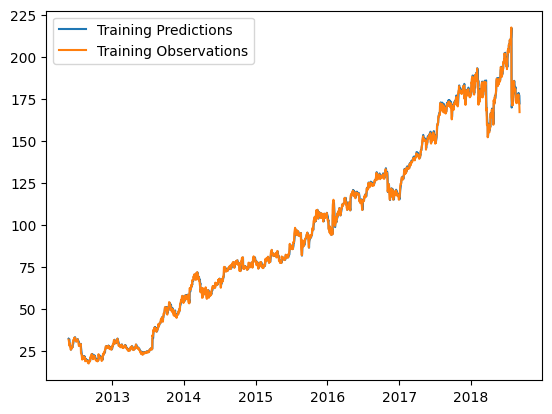

In [18]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

7/7 [==============================] - 0s 3ms/step


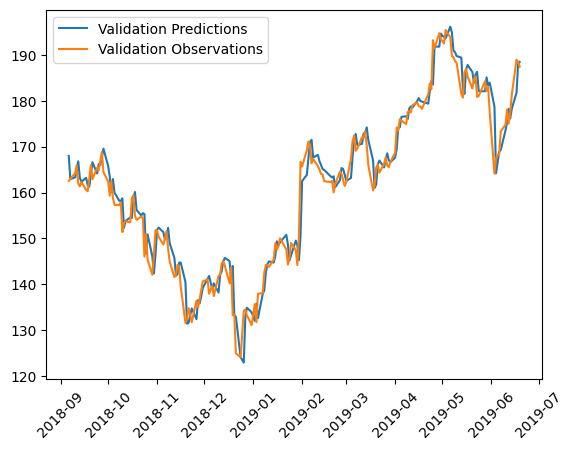

In [19]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.xticks(rotation=45)
plt.legend(['Validation Predictions', 'Validation Observations'])

7/7 [==============================] - 0s 2ms/step


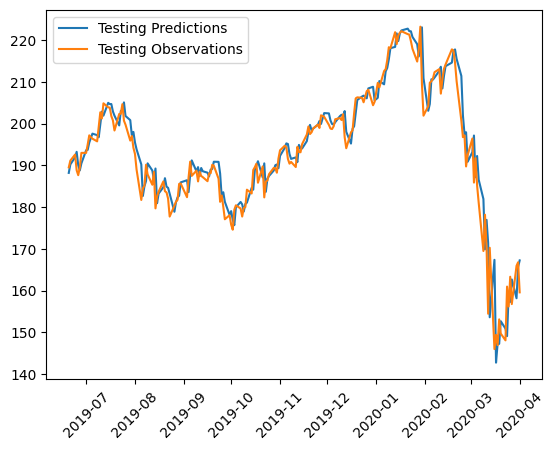

In [20]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xticks(rotation=45)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [21]:
# Predicting on the test set
y_pred = model.predict(X_test)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculating MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculating MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Creating a DataFrame with evaluation results
results = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE'],
    'Value': [rmse, mae, mape]
})

# Displaying the evaluation results
results

7/7 [==============================] - 0s 2ms/step


,Metric,Value
0,RMSE,4.326874
1,MAE,2.939489
2,MAPE,9.162953



*   RMSE sebesar 4.864462 menunjukkan bahwa, rata-rata, prediksi menyimpang dari nilai aktual sekitar 4.86 unit.

*   rata-rata, prediksi model meleset sekitar 3.55 unit.

*    rata-rata, prediksi meleset sekitar 9.4% dari nilai aktual.



# Arsitektur Baseline Normalized

In [22]:
# Normalize the data using Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the 'Close' column data
FB_stock_scaled = scaler.fit_transform(FB_stock)

# Convert the scaled data back to a DataFrame
FB_stock_scaled_df = pd.DataFrame(FB_stock_scaled, columns=["Close"], index=FB_stock.index)

FB_stock_scaled_df

,Close
Date,
2012-05-18,0.099757
2012-05-21,0.079319
2012-05-22,0.064574
2012-05-23,0.069440
2012-05-24,0.074453
...,...
2020-03-26,0.708564
2020-03-27,0.676691
2020-03-30,0.721265


In [23]:
# Start day second time around: '2012-05-29'
windowed_df_scaled = df_to_windowed_df(FB_stock_scaled_df,
                                '2012-05-25',
                                '2020-04-01',
                                n=5)
windowed_df_scaled

,Target Date,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2012-05-25,0.099757,0.079319,0.064574,0.069440,0.074453,0.069002
1,2012-05-29,0.079319,0.064574,0.069440,0.074453,0.069002,0.054063
2,2012-05-30,0.064574,0.069440,0.074453,0.069002,0.054063,0.050900
3,2012-05-31,0.069440,0.074453,0.069002,0.054063,0.050900,0.057762
4,2012-06-01,0.074453,0.069002,0.054063,0.050900,0.057762,0.048613
...,...,...,...,...,...,...,...
1970,2020-03-26,0.658881,0.642336,0.634404,0.697080,0.673869,0.708564
1971,2020-03-27,0.642336,0.634404,0.697080,0.673869,0.708564,0.676691
1972,2020-03-30,0.634404,0.697080,0.673869,0.708564,0.676691,0.721265
1973,2020-03-31,0.697080,0.673869,0.708564,0.676691,0.721265,0.725401


In [24]:
dates_scaled, X_scaled, y_scaled = windowed_df_to_date_X_y(windowed_df_scaled)

dates_scaled.shape, X_scaled.shape, y_scaled.shape

((1975,), (1975, 5, 1), (1975,))

# Split Data

In [25]:
# Calculate the split index for 80% training data
split_size80 = int(0.8 * len(dates_scaled)) # 80% train, 20% test

# Calculate the split index for 90% training and validation data
split_size90 = int(0.9 * len(dates_scaled)) # 90% train, 10% test

# Create train data splits (first 80% of the data)
dates_train, X_train_norm, y_train_norm = dates_scaled[:split_size80], X_scaled[:split_size80], y_scaled[:split_size80]
# Create validation data splits (next 10% of the data)
dates_val, X_val_norm, y_val_norm = dates_scaled[split_size80:split_size90], X_scaled[split_size80:split_size90], y_scaled[split_size80:split_size90]
# Create test data splits (last 10% of the data)
dates_test, X_test_norm, y_test_norm = dates_scaled[split_size90:], X_scaled[split_size90:], y_scaled[split_size90:]

# Print the lengths of the training, validation, and test datasets
print('Lenght of of X_train, y_train :', len(X_train_norm), len(y_train_norm))
print('Lenght of of X_val, y_val :', len(X_val_norm), len(y_val_norm))
print('Lenght of of X_test, y_test :', len(X_test_norm), len(y_test_norm))

Lenght of of X_train, y_train : 1580 1580
Lenght of of X_val, y_val : 197 197
Lenght of of X_test, y_test : 198 198


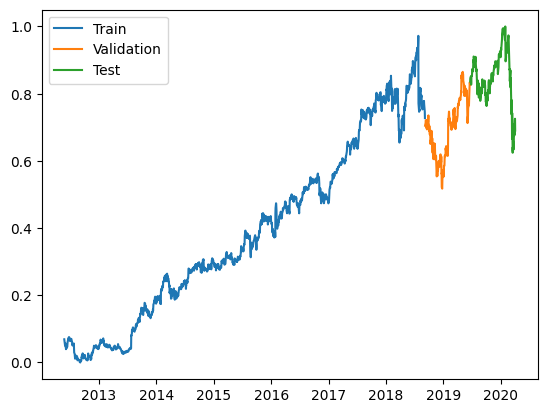

In [26]:
plt.plot(dates_train, y_train_norm)
plt.plot(dates_val, y_val_norm)
plt.plot(dates_test, y_test_norm)

plt.legend(['Train', 'Validation', 'Test'])

In [27]:
# Create a Sequential model
model_normalized = Sequential([
    layers.LSTM(50, activation='relu', input_shape=(5, 1)),  # LSTM layer with 50 units and ReLU activation
    layers.Dense(1)  # Dense layer with 1 node as the output
])

model_normalized.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history_normalized = model_normalized.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm, y_val_norm), epochs=100)

Epoch 1/100
50/50 [==============================] - 2s 14ms/step - loss: 0.0940 - mean_absolute_error: 0.2292 - val_loss: 0.0108 - val_mean_absolute_error: 0.0983
Epoch 2/100
50/50 [==============================] - 0s 8ms/step - loss: 9.1814e-04 - mean_absolute_error: 0.0205 - val_loss: 5.9685e-04 - val_mean_absolute_error: 0.0183
Epoch 3/100
50/50 [==============================] - 0s 8ms/step - loss: 2.3339e-04 - mean_absolute_error: 0.0098 - val_loss: 5.5177e-04 - val_mean_absolute_error: 0.0175
Epoch 4/100
50/50 [==============================] - 0s 9ms/step - loss: 2.0984e-04 - mean_absolute_error: 0.0093 - val_loss: 5.6613e-04 - val_mean_absolute_error: 0.0177
Epoch 5/100
50/50 [==============================] - 0s 9ms/step - loss: 2.0140e-04 - mean_absolute_error: 0.0090 - val_loss: 5.5412e-04 - val_mean_absolute_error: 0.0176
Epoch 6/100
50/50 [==============================] - 0s 9ms/step - loss: 1.9990e-04 - mean_absolute_error: 0.0087 - val_loss: 5.3831e-04 - val_mean_abso

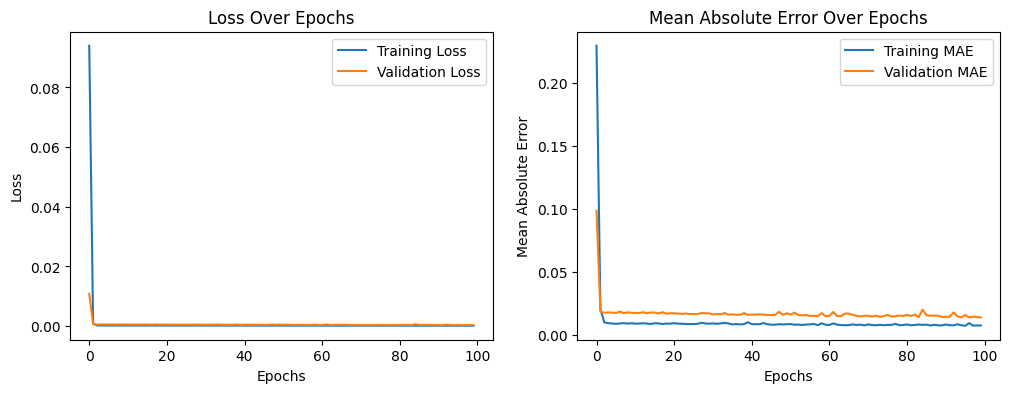

In [28]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_normalized.history['loss'], label='Training Loss')
plt.plot(history_normalized.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(history_normalized.history['mean_absolute_error'], label='Training MAE')
plt.plot(history_normalized.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

50/50 [==============================] - 0s 2ms/step


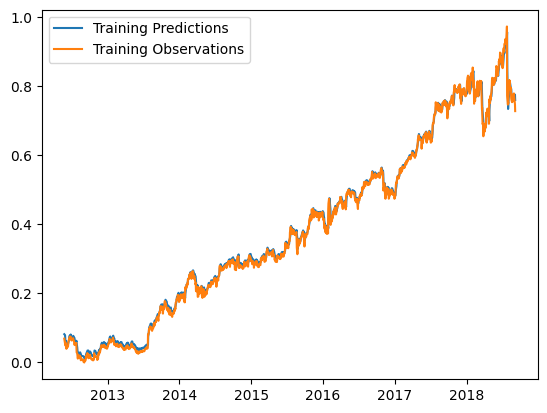

In [29]:
train_predictions = model_normalized.predict(X_train_norm).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train_norm)
plt.legend(['Training Predictions', 'Training Observations'])

7/7 [==============================] - 0s 2ms/step


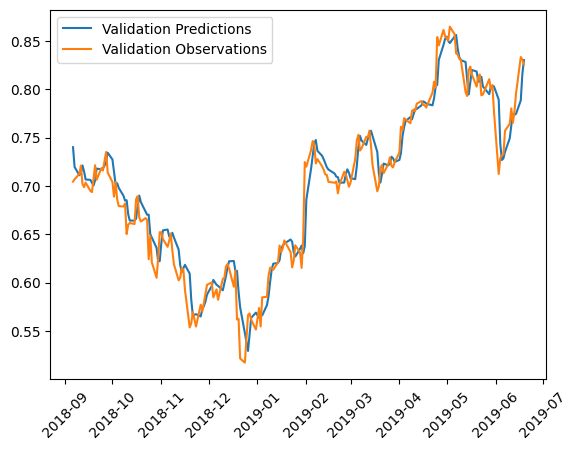

In [30]:
val_predictions = model_normalized.predict(X_val_norm).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val_norm)
plt.xticks(rotation=45)
plt.legend(['Validation Predictions', 'Validation Observations'])

7/7 [==============================] - 0s 3ms/step


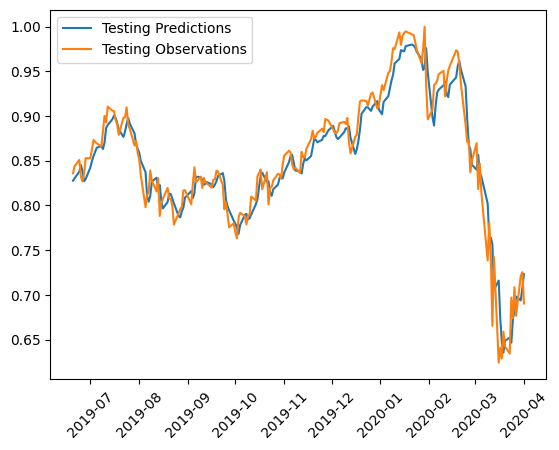

In [31]:
test_predictions = model_normalized.predict(X_test_norm).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test_norm)
plt.xticks(rotation=45)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [32]:
# Predicting on the test set
y_pred = model_normalized.predict(X_test_norm)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test_norm, y_pred))

# Calculating MAE
mae = mean_absolute_error(y_test_norm, y_pred)

# Calculating MAPE
mape = np.mean(np.abs((y_test_norm - y_pred) / y_test_norm)) * 100

# Creating a DataFrame with evaluation results
results = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE'],
    'Value': [rmse, mae, mape]
})

# Displaying the evaluation results
results

7/7 [==============================] - 0s 2ms/step


,Metric,Value
0,RMSE,0.020640
1,MAE,0.015624
2,MAPE,9.718728



*   RMSE sebesar 4.864462 menunjukkan bahwa, rata-rata, prediksi menyimpang dari nilai aktual sekitar 4.86 unit.

*   rata-rata, prediksi model meleset sekitar 3.55 unit.

*    rata-rata, prediksi meleset sekitar 9.4% dari nilai aktual.



# Modifikasi Arsitektur

In [33]:
model_modif = Sequential([
    layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(5, 1)),  # LSTM layer with 100 units and ReLU activation, return sequences
    layers.Dropout(0.2),  # Dropout layer to prevent overfitting
    layers.LSTM(50, activation='relu', return_sequences=False),  # Another LSTM layer with 50 units
    layers.Dropout(0.2),  # Another Dropout layer
    layers.Dense(1)  # Dense layer with 1 node as the output
])

model_modif.compile(loss='mse',
              optimizer=Adam(learning_rate=0.00001),
              metrics=['mean_absolute_error'])

history_modif = model_modif.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm, y_val_norm), epochs=200)

Epoch 1/200
50/50 [==============================] - 5s 22ms/step - loss: 0.2064 - mean_absolute_error: 0.3770 - val_loss: 0.4781 - val_mean_absolute_error: 0.6866
Epoch 2/200
50/50 [==============================] - 1s 16ms/step - loss: 0.2031 - mean_absolute_error: 0.3734 - val_loss: 0.4716 - val_mean_absolute_error: 0.6819
Epoch 3/200
50/50 [==============================] - 1s 21ms/step - loss: 0.1997 - mean_absolute_error: 0.3695 - val_loss: 0.4645 - val_mean_absolute_error: 0.6767
Epoch 4/200
50/50 [==============================] - 2s 32ms/step - loss: 0.1964 - mean_absolute_error: 0.3656 - val_loss: 0.4569 - val_mean_absolute_error: 0.6711
Epoch 5/200
50/50 [==============================] - 1s 20ms/step - loss: 0.1928 - mean_absolute_error: 0.3614 - val_loss: 0.4488 - val_mean_absolute_error: 0.6651
Epoch 6/200
50/50 [==============================] - 1s 17ms/step - loss: 0.1894 - mean_absolute_error: 0.3573 - val_loss: 0.4406 - val_mean_absolute_error: 0.6589
Epoch 7/200
50/5

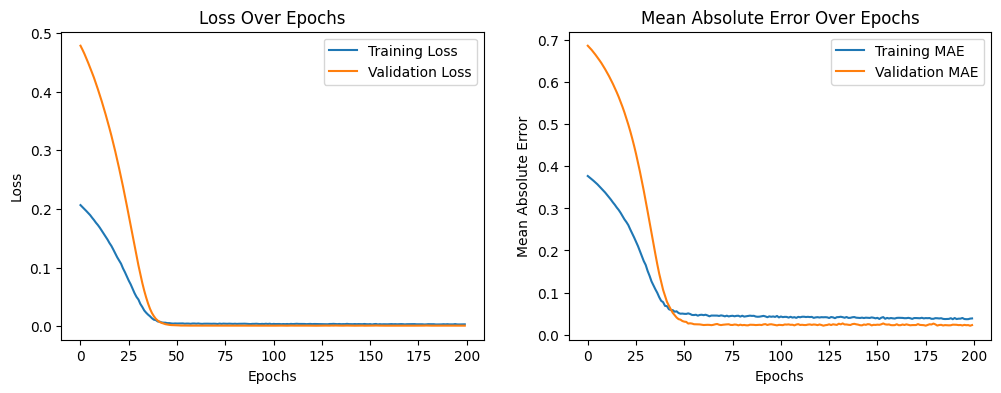

In [34]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_modif.history['loss'], label='Training Loss')
plt.plot(history_modif.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(history_modif.history['mean_absolute_error'], label='Training MAE')
plt.plot(history_modif.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

50/50 [==============================] - 0s 3ms/step


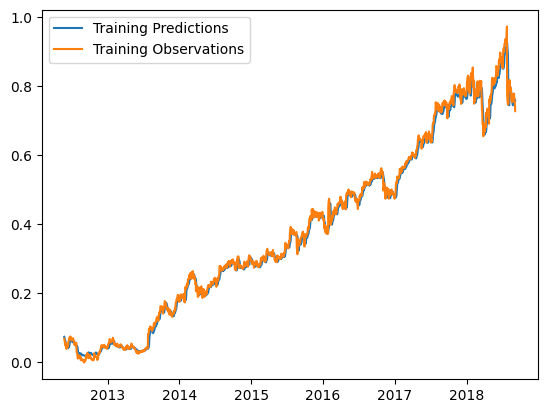

In [35]:
train_predictions = model_modif.predict(X_train_norm).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train_norm)
plt.legend(['Training Predictions', 'Training Observations'])

7/7 [==============================] - 0s 3ms/step


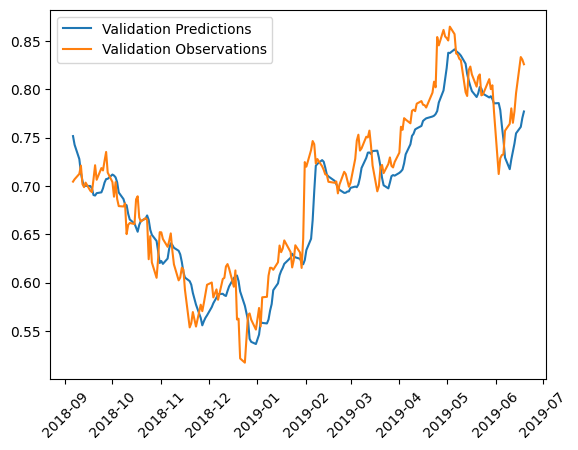

In [36]:
val_predictions = model_modif.predict(X_val_norm).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val_norm)
plt.xticks(rotation=45)
plt.legend(['Validation Predictions', 'Validation Observations'])

7/7 [==============================] - 0s 3ms/step


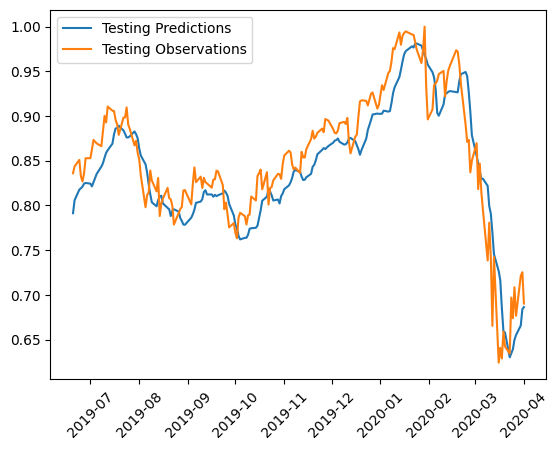

In [37]:
test_predictions = model_modif.predict(X_test_norm).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test_norm)
plt.xticks(rotation=45)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [38]:
# Predicting on the test set
y_pred = model_modif.predict(X_test_norm)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test_norm, y_pred))

# Calculating MAE
mae = mean_absolute_error(y_test_norm, y_pred)

# Calculating MAPE
mape = np.mean(np.abs((y_test_norm - y_pred) / y_test_norm)) * 100

# Creating a DataFrame with evaluation results
results = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE'],
    'Value': [rmse, mae, mape]
})

# Displaying the evaluation results
results

7/7 [==============================] - 0s 3ms/step


,Metric,Value
0,RMSE,0.032076
1,MAE,0.026467
2,MAPE,9.857146


# Modifikasi Arsitektur GRU

In [39]:
model_modifgru = Sequential([
    layers.Bidirectional(GRU(50, activation='relu', return_sequences=True), input_shape=(5, 1)),  # Bidirectional GRU layer
    layers.Dropout(0.2),  # Dropout layer to prevent overfitting
    layers.GRU(50, activation='relu'),  # Another GRU layer
    layers.Dropout(0.2),  # Another Dropout layer
    layers.Dense(1)  # Dense layer with 1 node as the output
])

model_modifgru.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history_modifgru = model_modifgru.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm, y_val_norm), epochs=100)

Epoch 1/100
50/50 [==============================] - 7s 38ms/step - loss: 0.0686 - mean_absolute_error: 0.1887 - val_loss: 0.0073 - val_mean_absolute_error: 0.0801
Epoch 2/100
50/50 [==============================] - 1s 27ms/step - loss: 0.0049 - mean_absolute_error: 0.0502 - val_loss: 7.1980e-04 - val_mean_absolute_error: 0.0212
Epoch 3/100
50/50 [==============================] - 1s 28ms/step - loss: 0.0037 - mean_absolute_error: 0.0428 - val_loss: 9.9945e-04 - val_mean_absolute_error: 0.0256
Epoch 4/100
50/50 [==============================] - 1s 29ms/step - loss: 0.0031 - mean_absolute_error: 0.0390 - val_loss: 5.3240e-04 - val_mean_absolute_error: 0.0172
Epoch 5/100
50/50 [==============================] - 1s 27ms/step - loss: 0.0030 - mean_absolute_error: 0.0377 - val_loss: 6.6070e-04 - val_mean_absolute_error: 0.0199
Epoch 6/100
50/50 [==============================] - 1s 27ms/step - loss: 0.0027 - mean_absolute_error: 0.0357 - val_loss: 6.8935e-04 - val_mean_absolute_error: 0.0

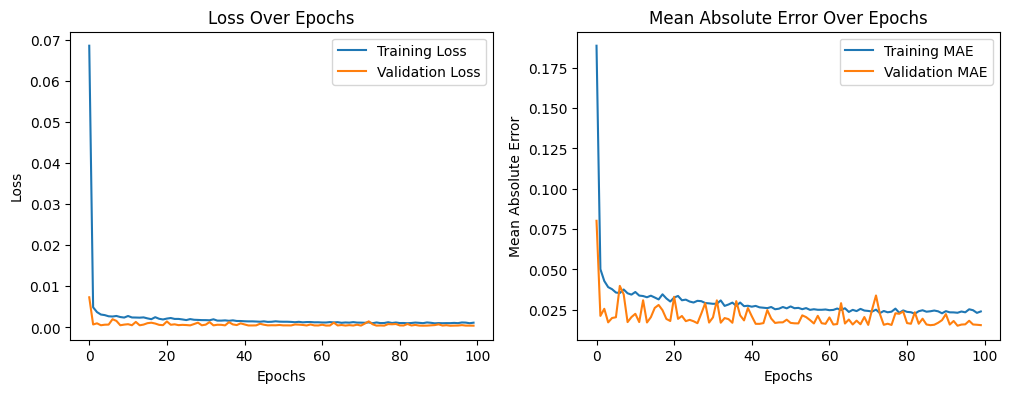

In [40]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_modifgru.history['loss'], label='Training Loss')
plt.plot(history_modifgru.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(history_modifgru.history['mean_absolute_error'], label='Training MAE')
plt.plot(history_modifgru.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

50/50 [==============================] - 1s 5ms/step


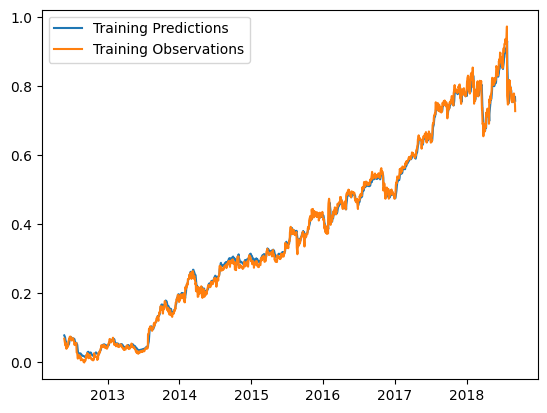

In [41]:
train_predictions = model_modifgru.predict(X_train_norm).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train_norm)
plt.legend(['Training Predictions', 'Training Observations'])

7/7 [==============================] - 0s 4ms/step


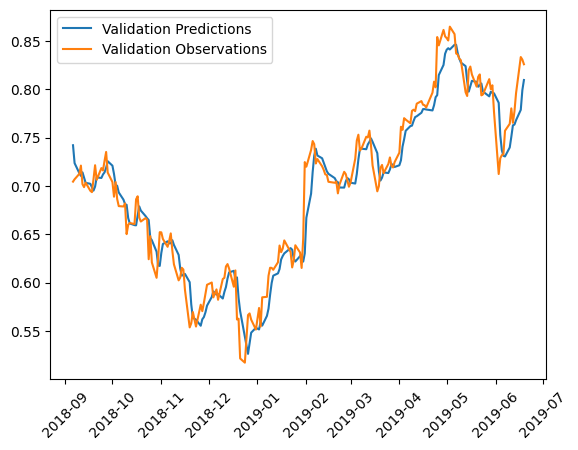

In [42]:
val_predictions = model_modifgru.predict(X_val_norm).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val_norm)
plt.xticks(rotation=45)
plt.legend(['Validation Predictions', 'Validation Observations'])

7/7 [==============================] - 0s 4ms/step


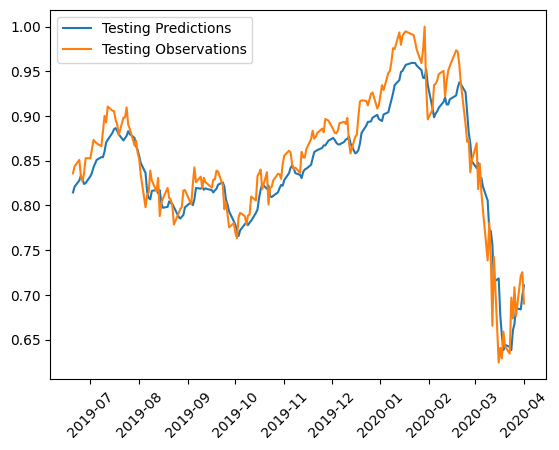

In [43]:
test_predictions = model_modifgru.predict(X_test_norm).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test_norm)
plt.xticks(rotation=45)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [44]:
# Predicting on the test set
y_pred = model_modifgru.predict(X_test_norm)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test_norm, y_pred))

# Calculating MAE
mae = mean_absolute_error(y_test_norm, y_pred)

# Calculating MAPE
mape = np.mean(np.abs((y_test_norm - y_pred) / y_test_norm)) * 100

# Creating a DataFrame with evaluation results
results = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE'],
    'Value': [rmse, mae, mape]
})

# Displaying the evaluation results
results

7/7 [==============================] - 0s 5ms/step


,Metric,Value
0,RMSE,0.026023
1,MAE,0.021129
2,MAPE,9.484588


# IBM

# Explore Data and Preprocessing

In [45]:
# Load dataset
df_ibm = pd.read_csv('IBM.csv', parse_dates=['Date'],index_col=['Date'])
df_ibm

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,7.713333,7.713333,7.626667,7.626667,0.618153,387200
1962-01-03,7.626667,7.693333,7.626667,7.693333,0.623556,288000
1962-01-04,7.693333,7.693333,7.613333,7.616667,0.617343,256000
1962-01-05,7.606667,7.606667,7.453333,7.466667,0.605185,363200
1962-01-08,7.460000,7.460000,7.266667,7.326667,0.593837,544000
...,...,...,...,...,...,...
2020-03-26,106.910004,113.150002,105.570000,112.889999,112.889999,7153500
2020-03-27,108.580002,111.500000,107.650002,108.029999,108.029999,6423000
2020-03-30,108.089996,113.459999,107.809998,112.930000,112.930000,5564500


In [46]:
df_ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14663 entries, 1962-01-02 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       14663 non-null  float64
 1   High       14663 non-null  float64
 2   Low        14663 non-null  float64
 3   Close      14663 non-null  float64
 4   Adj Close  14663 non-null  float64
 5   Volume     14663 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 801.9 KB


In [47]:
# Take only column 'Close'
IBM_stock = pd.DataFrame(df_ibm["Close"])
IBM_stock.head(20)

,Close
Date,
1962-01-02,7.626667
1962-01-03,7.693333
1962-01-04,7.616667
1962-01-05,7.466667
1962-01-08,7.326667
1962-01-09,7.413333
1962-01-10,7.426667
1962-01-11,7.506667
1962-01-12,7.520000


In [48]:
IBM_stock.describe()

,Close
count,14663.000000
mean,60.140033
std,57.353260
min,4.080000
25%,16.110937
50%,28.656250
75%,102.311249
max,215.800003


In [49]:
# Fit and transform the 'Close' column data
IBM_stock_scaled = scaler.fit_transform(IBM_stock)

# Convert the scaled data back to a DataFrame
IBM_stock_scaled_df = pd.DataFrame(IBM_stock_scaled, columns=["Close"], index=IBM_stock.index)

IBM_stock_scaled_df.head(20)

,Close
Date,
1962-01-02,0.016752
1962-01-03,0.017067
1962-01-04,0.016704
1962-01-05,0.015996
1962-01-08,0.015335
1962-01-09,0.015744
1962-01-10,0.015807
1962-01-11,0.016185
1962-01-12,0.016248


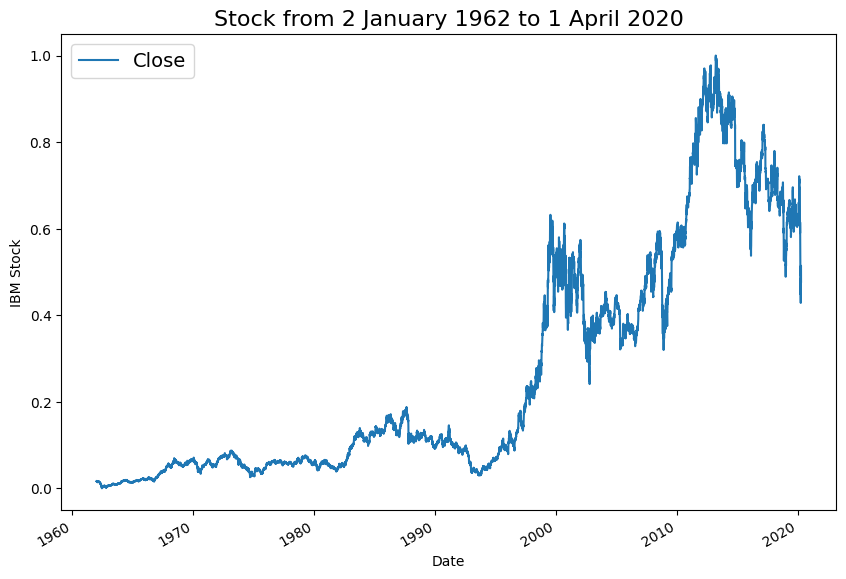

In [76]:
# Plot the time series
IBM_stock_scaled_df.plot(figsize=(10, 7))
plt.ylabel("IBM Stock") # Label for y-axis
plt.title("Stock from 2 January 1962 to 1 April 2020", fontsize=16) # Title for plot
plt.legend(fontsize=14); #Legend for the plot

In [51]:
# Start day second time around: '2012-05-29'
windowed_IBM = df_to_windowed_df(IBM_stock_scaled_df,
                                '1962-01-09',
                                '2020-04-01',
                                n=5)
windowed_IBM

,Target Date,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,1962-01-09,0.016752,0.017067,0.016704,0.015996,0.015335,0.015744
1,1962-01-10,0.017067,0.016704,0.015996,0.015335,0.015744,0.015807
2,1962-01-11,0.016704,0.015996,0.015335,0.015744,0.015807,0.016185
3,1962-01-12,0.015996,0.015335,0.015744,0.015807,0.016185,0.016248
4,1962-01-15,0.015335,0.015744,0.015807,0.016185,0.016248,0.016405
...,...,...,...,...,...,...,...
14653,2020-03-26,0.454657,0.431277,0.428349,0.478934,0.480682,0.513933
14654,2020-03-27,0.431277,0.428349,0.478934,0.480682,0.513933,0.490979
14655,2020-03-30,0.428349,0.478934,0.480682,0.513933,0.490979,0.514122
14656,2020-03-31,0.478934,0.480682,0.513933,0.490979,0.514122,0.504676


In [52]:
dates_IBM, X_IBM, y_IBM = windowed_df_to_date_X_y(windowed_IBM)

dates_IBM.shape, X_IBM.shape, y_IBM.shape

((14658,), (14658, 5, 1), (14658,))

# Split Data

In [53]:
# Calculate the split index for 80% training data
split_size80 = int(0.8 * len(dates_IBM)) # 80% train, 20% test

# Calculate the split index for 90% training and validation data
split_size90 = int(0.9 * len(dates_IBM)) # 90% train, 10% test

# Create train data splits (first 80% of the data)
dates_train, X_train, y_train = dates_IBM[:split_size80], X_IBM[:split_size80], y_IBM[:split_size80]
# Create validation data splits (next 10% of the data)
dates_val, X_val, y_val = dates_IBM[split_size80:split_size90], X_IBM[split_size80:split_size90], y_IBM[split_size80:split_size90]
# Create test data splits (last 10% of the data)
dates_test, X_test, y_test = dates_IBM[split_size90:], X_IBM[split_size90:], y_IBM[split_size90:]

# Print the lengths of the training, validation, and test datasets
print('Lenght of of X_train, y_train :', len(X_train), len(y_train))
print('Lenght of of X_val, y_val :', len(X_val), len(y_val))
print('Lenght of of X_test, y_test :', len(X_test), len(y_test))

Lenght of of X_train, y_train : 11726 11726
Lenght of of X_val, y_val : 1466 1466
Lenght of of X_test, y_test : 1466 1466


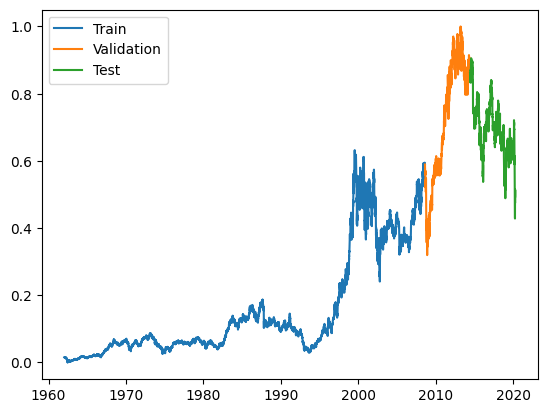

In [54]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

# Arsitektur Baseline

In [55]:
# Create a Sequential model
model = Sequential([
    layers.LSTM(50, activation='relu', input_shape=(5, 1)),  # LSTM layer with 50 units and ReLU activation
    layers.Dense(1)  # Dense layer with 1 node as the output
])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

historyibm = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
367/367 [==============================] - 6s 11ms/step - loss: 0.0026 - mean_absolute_error: 0.0173 - val_loss: 7.2175e-04 - val_mean_absolute_error: 0.0202
Epoch 2/100
367/367 [==============================] - 3s 8ms/step - loss: 4.3143e-05 - mean_absolute_error: 0.0035 - val_loss: 7.3074e-04 - val_mean_absolute_error: 0.0203
Epoch 3/100
367/367 [==============================] - 3s 8ms/step - loss: 4.3322e-05 - mean_absolute_error: 0.0035 - val_loss: 6.4332e-04 - val_mean_absolute_error: 0.0191
Epoch 4/100
367/367 [==============================] - 4s 10ms/step - loss: 4.3585e-05 - mean_absolute_error: 0.0037 - val_loss: 6.7007e-04 - val_mean_absolute_error: 0.0196
Epoch 5/100
367/367 [==============================] - 3s 9ms/step - loss: 4.3772e-05 - mean_absolute_error: 0.0037 - val_loss: 9.7085e-04 - val_mean_absolute_error: 0.0236
Epoch 6/100
367/367 [==============================] - 3s 8ms/step - loss: 4.3336e-05 - mean_absolute_error: 0.0037 - val_loss: 0.0012 - 

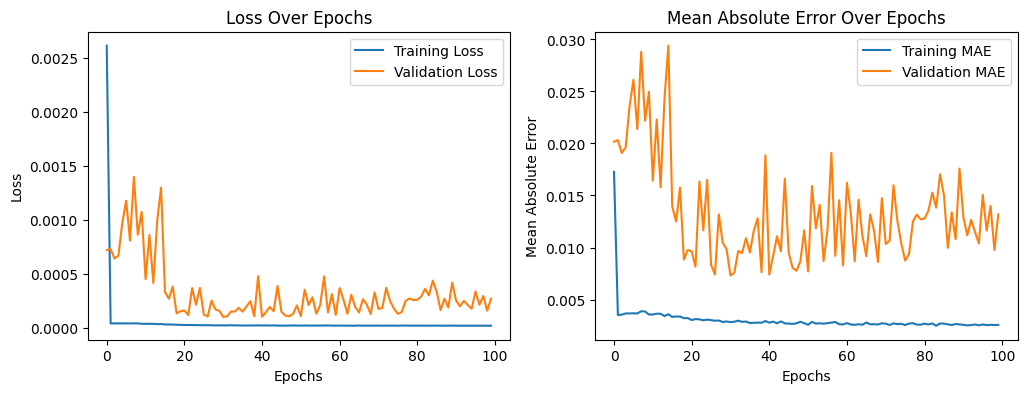

In [56]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(historyibm.history['loss'], label='Training Loss')
plt.plot(historyibm.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(historyibm.history['mean_absolute_error'], label='Training MAE')
plt.plot(historyibm.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

367/367 [==============================] - 1s 2ms/step


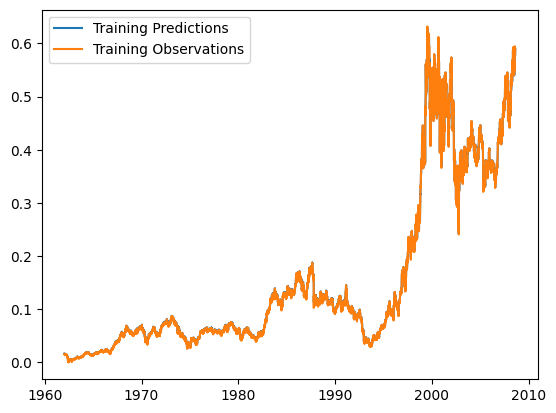

In [57]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

46/46 [==============================] - 0s 2ms/step


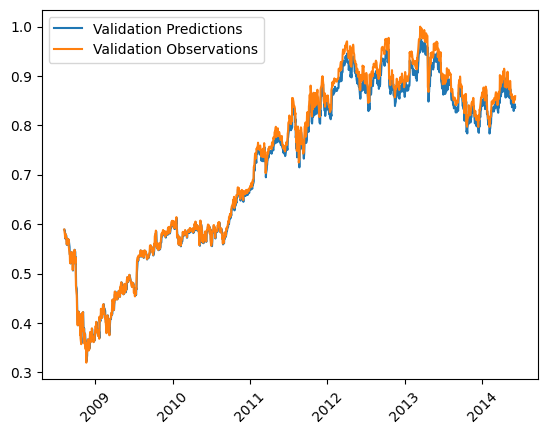

In [58]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.xticks(rotation=45)
plt.legend(['Validation Predictions', 'Validation Observations'])

46/46 [==============================] - 0s 2ms/step


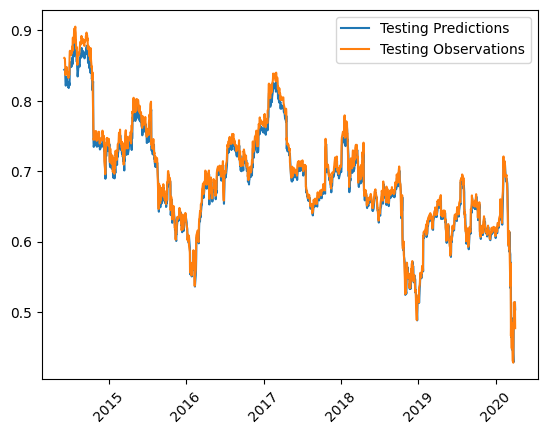

In [59]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xticks(rotation=45)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [60]:
# Predicting on the test set
y_pred = model.predict(X_test)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculating MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculating MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Creating a DataFrame with evaluation results
results = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE'],
    'Value': [rmse, mae, mape]
})

# Displaying the evaluation results
results

46/46 [==============================] - 0s 3ms/step


,Metric,Value
0,RMSE,0.012043
1,MAE,0.009197
2,MAPE,12.601626


# Modifikasi Arsitektur

In [61]:
model_modif.compile(loss='mse',
              optimizer=Adam(learning_rate=0.00001),
              metrics=['mean_absolute_error'])

history_modif = model_modif.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200)

Epoch 1/200
367/367 [==============================] - 10s 21ms/step - loss: 6.8246e-04 - mean_absolute_error: 0.0169 - val_loss: 6.4883e-04 - val_mean_absolute_error: 0.0209
Epoch 2/200
367/367 [==============================] - 6s 16ms/step - loss: 6.8965e-04 - mean_absolute_error: 0.0166 - val_loss: 6.3331e-04 - val_mean_absolute_error: 0.0205
Epoch 3/200
367/367 [==============================] - 7s 19ms/step - loss: 6.9022e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0010 - val_mean_absolute_error: 0.0270
Epoch 4/200
367/367 [==============================] - 6s 15ms/step - loss: 6.6852e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0013 - val_mean_absolute_error: 0.0316
Epoch 5/200
367/367 [==============================] - 7s 19ms/step - loss: 6.5468e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0011 - val_mean_absolute_error: 0.0283
Epoch 6/200
367/367 [==============================] - 6s 15ms/step - loss: 6.3510e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0012 - val

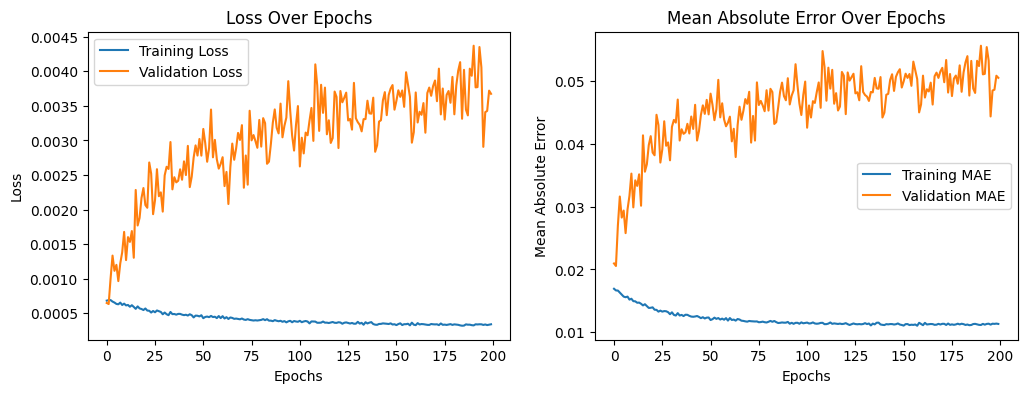

In [62]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_modif.history['loss'], label='Training Loss')
plt.plot(history_modif.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(history_modif.history['mean_absolute_error'], label='Training MAE')
plt.plot(history_modif.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

367/367 [==============================] - 2s 3ms/step


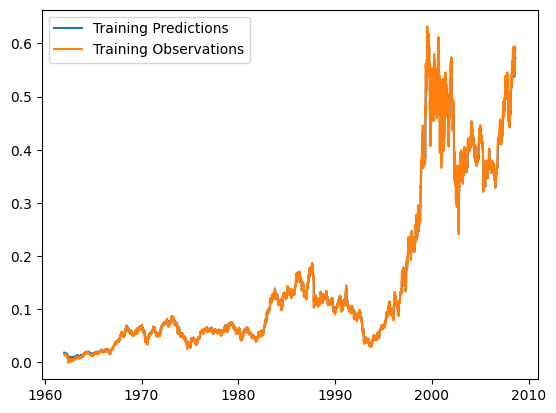

In [63]:
train_predictions = model_modif.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

46/46 [==============================] - 0s 3ms/step


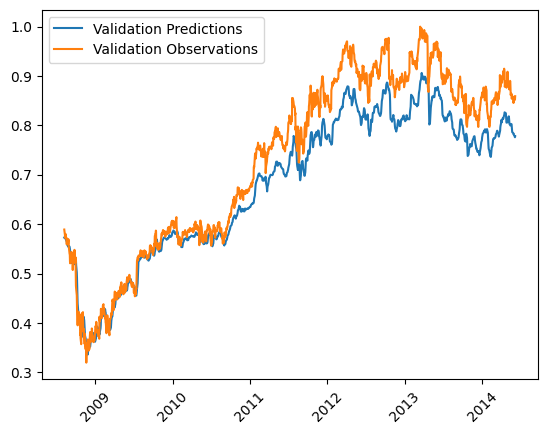

In [64]:
val_predictions = model_modif.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.xticks(rotation=45)
plt.legend(['Validation Predictions', 'Validation Observations'])

46/46 [==============================] - 0s 3ms/step


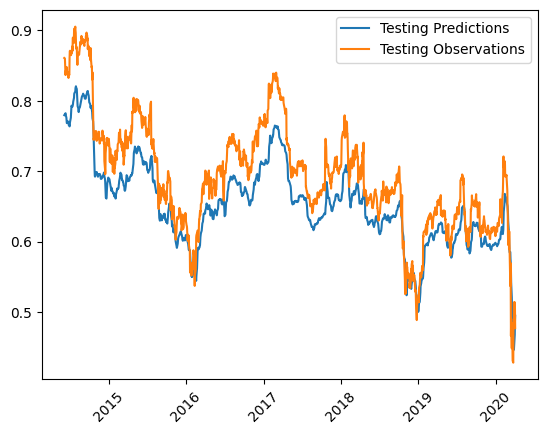

In [65]:
test_predictions = model_modif.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xticks(rotation=45)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [66]:
# Predicting on the test set
y_pred = model_modif.predict(X_test)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculating MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculating MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Creating a DataFrame with evaluation results
results = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE'],
    'Value': [rmse, mae, mape]
})

# Displaying the evaluation results
results

46/46 [==============================] - 0s 3ms/step


,Metric,Value
0,RMSE,0.046264
1,MAE,0.041412
2,MAPE,12.063605


# Modifikasi Arsitektur GRU

In [68]:
model_modifgru.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history_modifgru = model_modifgru.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
367/367 [==============================] - 15s 31ms/step - loss: 7.0275e-04 - mean_absolute_error: 0.0203 - val_loss: 0.0053 - val_mean_absolute_error: 0.0614
Epoch 2/100
367/367 [==============================] - 11s 30ms/step - loss: 4.3928e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0015 - val_mean_absolute_error: 0.0331
Epoch 3/100
367/367 [==============================] - 11s 30ms/step - loss: 3.8543e-04 - mean_absolute_error: 0.0140 - val_loss: 0.0015 - val_mean_absolute_error: 0.0331
Epoch 4/100
367/367 [==============================] - 12s 34ms/step - loss: 3.6243e-04 - mean_absolute_error: 0.0134 - val_loss: 0.0021 - val_mean_absolute_error: 0.0411
Epoch 5/100
367/367 [==============================] - 11s 30ms/step - loss: 3.9092e-04 - mean_absolute_error: 0.0133 - val_loss: 0.0035 - val_mean_absolute_error: 0.0535
Epoch 6/100
367/367 [==============================] - 10s 26ms/step - loss: 3.6552e-04 - mean_absolute_error: 0.0130 - val_loss: 7.8075e-04 - va

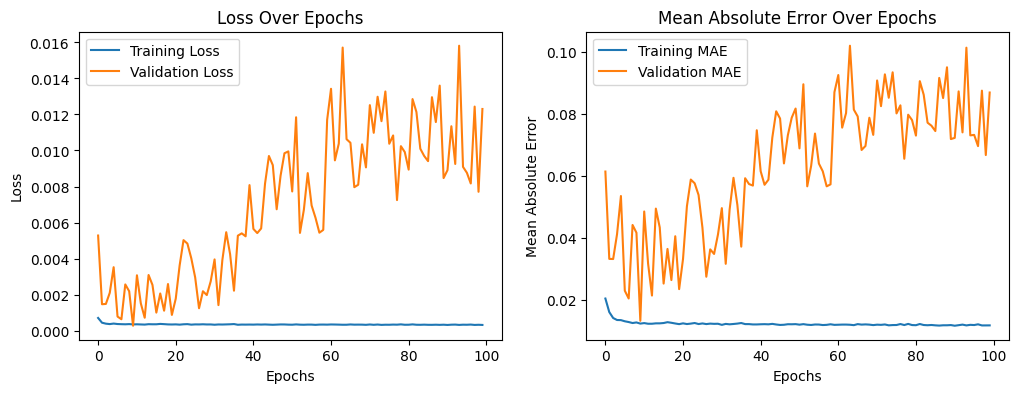

In [69]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_modifgru.history['loss'], label='Training Loss')
plt.plot(history_modifgru.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(history_modifgru.history['mean_absolute_error'], label='Training MAE')
plt.plot(history_modifgru.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()

367/367 [==============================] - 2s 4ms/step


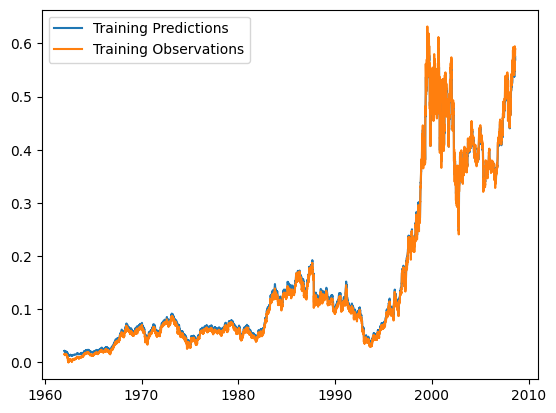

In [70]:
train_predictions = model_modifgru.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

46/46 [==============================] - 0s 4ms/step


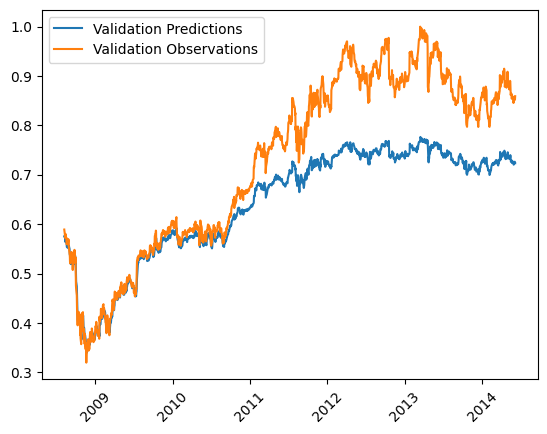

In [71]:
val_predictions = model_modifgru.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.xticks(rotation=45)
plt.legend(['Validation Predictions', 'Validation Observations'])

46/46 [==============================] - 0s 5ms/step


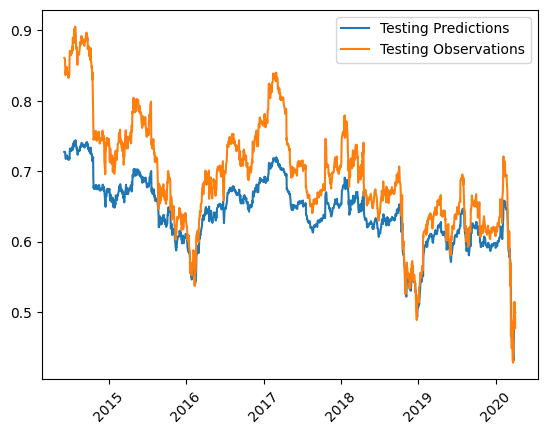

In [72]:
test_predictions = model_modifgru.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xticks(rotation=45)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [74]:
# Predicting on the test set
y_pred = model_modifgru.predict(X_test)

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculating MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculating MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Creating a DataFrame with evaluation results
results = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE'],
    'Value': [rmse, mae, mape]
})

# Displaying the evaluation results
results

46/46 [==============================] - 0s 4ms/step


,Metric,Value
0,RMSE,0.062934
1,MAE,0.053285
2,MAPE,11.649600
